In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import numpy as np
import pandas as pd
import gudhi

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query, get_flight_persistances

from scipy.cluster.hierarchy import fcluster
from matplotlib import pyplot as plt

In [135]:
# load minimum data set
df = pd.read_csv("data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2020, month=3, day=1).replace(
    tzinfo=datetime.timezone.utc
)

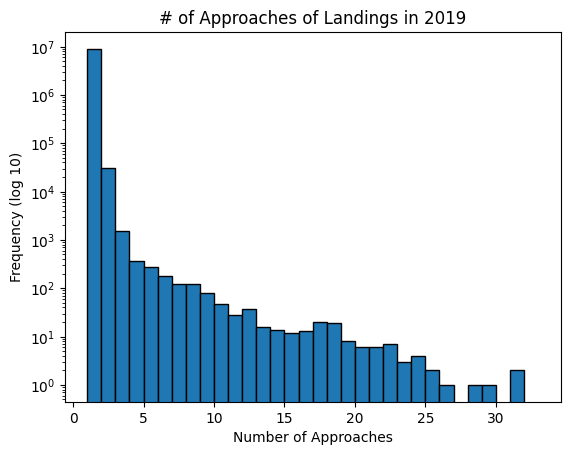

In [157]:
plt.figure()
plt.hist(df["n_approaches"], log=True, bins=range(1, 34), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.title("# of Approaches of Landings in 2019")
plt.savefig("approach_histogram.svg", format="svg")
#plt.close()

In [137]:
with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

In [138]:
without_GA = without_GA.sample(n=with_GA.shape[0], random_state=42)
query = pd.concat([with_GA, without_GA], axis=0)

In [139]:
file_name = "balanced1_2"
flights, labels = flights_from_query(query, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)

In [151]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")
approach_4 = df.query(f"n_approaches==4 & (@start <= time <= @stop)")

count_4 = approach_4.shape[0]
count_3 = min(approach_3.shape[0], count_4*2)
count_2 = min(approach_2.shape[0], count_3*2)
count_1 = min(approach_1.shape[0], count_2*2)

approach_3 = approach_3.sample(n=count_3, random_state=42)
approach_2 = approach_2.sample(n=count_2, random_state=42)
approach_1 = approach_1.sample(n=count_1, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3, approach_4], axis=0)

In [152]:
len(query)

5580

In [153]:
file_name = "unbalanced1_2_3_4"
flights, labels = flights_from_query(query, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)
len(labels)

3893

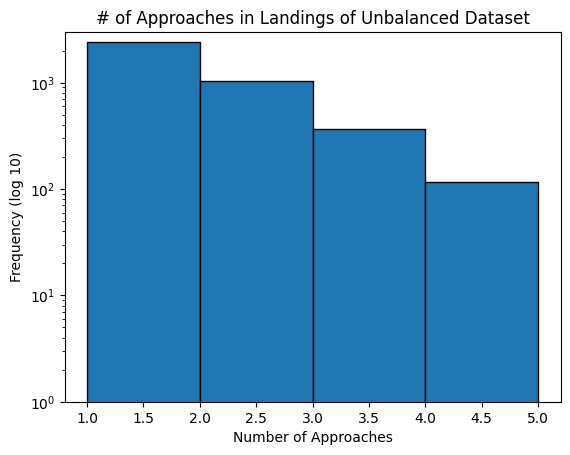

In [143]:
data = labels[:, 0]

plt.figure()
y, _, _ = plt.hist(data, log=True, bins=range(1, 6), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.ylim(1, max(y)*1.25 )
plt.title("# of Approaches in Landings of Unbalanced Dataset")
plt.savefig("unbalanced_1_2_3_4_approach_histogram.svg", format="svg")
#plt.close()

In [154]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")

count = approach_3.shape[0]

approach_2 = approach_2.sample(n=count, random_state=42)
approach_1 = approach_1.sample(n=count, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3], axis=0)

In [155]:
len(query)

4599

In [156]:
file_name = "balanced1_2_3"
flights, labels = flights_from_query(query, file_name, load_results=True)
data = get_flight_persistances(flights, file_name, load_results=True)
len(labels)

3037

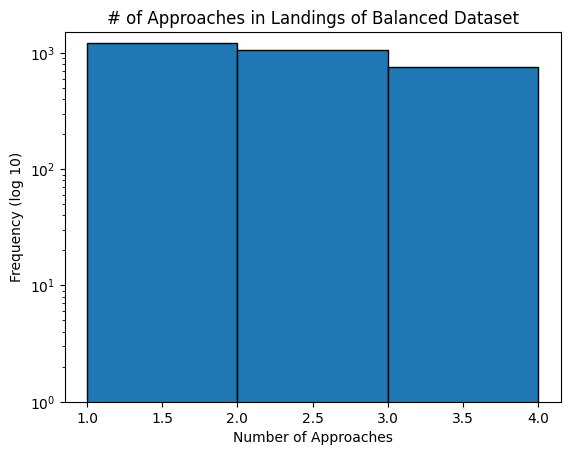

In [147]:
data = labels[:, 0]

plt.figure()
y, _, _ = plt.hist(data, log=True, bins=range(1, 5), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.ylim(1, max(y)*1.25 )
plt.title("# of Approaches in Landings of Balanced Dataset")
plt.savefig("balanced_1_2_3_approach_histogram.svg", format="svg")
#plt.close()

In [21]:
len(flights)

3037

In [32]:
trees, paths = sublevelset_persistence(flights[:1000], "geoaltitude")

100%|██████████| 1000/1000 [00:06<00:00, 159.82it/s]


In [33]:
path = f"../../data/linkage_clustering/cyclic_dataset.pkl"
Z = linkage_cluster_persistances(trees, path=path, load_results=False)

100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


In [34]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 55
2: 12
3: 554
4: 345
5: 11
6: 6
7: 3
8: 1
9: 2
10: 11


In [38]:
from matplotlib import pyplot as plt

ind = 10

flight = flights[np.where(clustering == ind)[0][0]]
tree = trees[np.where(clustering == ind)[0][0]]
points = paths[np.where(clustering == ind)[0][0]]
before = flight.data[["geoaltitude"]].to_numpy()
before = np.column_stack((np.arange(len(data)), before))

dbscan_paths        = before[remove_outliers_dbscan(before, 25, eps = 0.05)]
z_score_paths       = before[remove_outliers_z_score(before)]

path_filters = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan")]

fig, axs = plt.subplots(3)#, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i].scatter(path[:, 0], path[:, 1])
    axs[i].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10620 and the array at index 1 has size 1800

In [8]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(tree, axes=axs[1])
print(tree)

C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

In [ ]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()